# Решение задачи теплопроводности с постоянными коэффициентами

<h3>* Этот файл является примером научного кода, поэтому написан так, чтобы оптимизировать решение поставленной задачи. </h3>
    <h3>* Чтобы воспользоваться этой реализацией, необходимо понимать, что такое неявная разностная схема - это знание необходимо, чтобы правильно задать граничные условия для конкретной задачи.</h3>
    <h3>* В представленном в этом файле примере имеются нелинейные граничные условия, так что для корректного решения используется линейное приближение нелинейных гран. условий (где в таком случае фигурирует значение температуры на левой границе на предыдущем временном слое), и для вычисления каждого временного шага производится несколько итераций с целью как можно лучше приблизить значение температуры на левой границе расчетной области. Если граничные условия в задаче линейные, количество итераций просто нужно выставить равными 1</h3>

In [2]:
"""import IPython 
%matplotlib ipympl
from mpl_toolkits.mplot3d import Axes3D"""

'import IPython \n%matplotlib ipympl\nfrom mpl_toolkits.mplot3d import Axes3D'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
from copy import deepcopy
from numba import njit
from scipy.interpolate import CubicSpline
from matplotlib.ticker import NullFormatter, FormatStrFormatter

In [2]:
%config IPCompleter.greedy=True

**Эта функция добавляет в определенный индекс каждого numpy.array соответствующую ему добавку. это вспомогательная функция**

In [3]:
def add(objs, adds, idx=0):
    for obj, add in zip(objs, adds):
        obj[idx] += add

**Решать задачу будем с помощью неявной разностной схемы. Это значит, что у нас будет трехдиагональная матрица СЛАУ, которю нужно будет решить. На собственном опыте проверено, что метод прогонки намного быстрее стандартных методов решения такого типа систем уравнений. Кроме того, в случае использоапния самописного метода прогонки, а не использования таких инструментов как dcipy.linalg.solve, возможно существенное ускорение вычислений при помощи декоратора @njit из библиотеки numba.**

In [7]:
@njit
def progonka(result, a, b, c, d):
    A = np.zeros(len(d)-1, dtype='float64')
    B = np.zeros(len(d)-1, dtype='float64')

    A[0] = - c[0] / b[0]
    B[0] = d[0] / b[0]

    for m in range(1, len(A)):
        A[m] = - c[1] / (b[1] + a[1] * A[m - 1])
        B[m] = (d[m] - a[1] * B[m - 1]) / (b[1] + a[1] * A[m - 1])

    result[-2] = (d[-1] - a[2] * B[-1]) / (b[2] + a[2] * A[-1])

    for m in range(len(result) - 3, 0, -1):
        result[m] = A[m - 1] * result[m + 1] + B[m - 1]


**Это функция источника. В качестве примера используется случай, когда покровное стекло солнечных батарей космических аппаратов К-208 подвергается воздействию электронного излучения с энергией 30 кэВ, что соответствует энергиям электронов в горячей магнитосферной плазме Земли. Энергопотери электронов внутри стекла были получены вычислены с помощью програмного комплекса Geant4.**

In [27]:
def source(x, properties):
    eV = 1.6e-19 # J
    
    data = pd.read_csv(properties['source_path'], header=None)
    #data.loc[:, 0] /= 1e3 # mkm
    x_pts = np.array(data.loc[:, 0])
    data.loc[:, 1] *= (eV * 1e3) # J / mkm
    de_dx = CubicSpline(x_pts, data.loc[:, 1])

    start = 0.
    end = 0.
    flag = False
    source_func = np.array([0.]*(len(x)-2), dtype='float64') # это будущая правая часть слау
    for i, point in enumerate(x[1:]):
        if point >= x_pts[-1]: # если новая точка дальше, чем проникают частицы
            end = x_pts[-1]
            flag = True
        else:
            end = point
        x_integr = np.linspace(start, end, 50)
        new_de_dx = np.trapz(de_dx(x_integr), x=x_integr) / (point - start) # пересчитываем производную, так как у нас теперь другой шаг
        source_func[i] = new_de_dx * properties['flux_dens'] / (properties['heat_capacity'] * properties['density'])
        if flag:  # дальше только 0
            break
        start = end

    return source_func

**Начальное условие**

In [13]:
def init_cond(x):
    u_init = 293.
    return np.array([u_init]*len(x), dtype='float64')

### Немного о граничных условиях

* Предполагается, что пользователь знает, что такое неявная разностная схема.
* Коэффициент $a$ находится перед переменной $T_{m-1}^{n+1}$, коэф. $b$ - перед $T_{m}^{n+1}$, $c$ - перед $T_{m+1}^{n+1},$ где $n$ - рассчитываемый временной слой, $m$ - номер пространственной ячейки. Нумерация ведется с 0.
* На границе ставятся различные условия в зависимости от задачи, а значит определенным образом изменяются коэффициенты $a, b, c$ и правая часть СЛАУ в нулевой и последней строке СЛАУ. В других строках эти константы вычисляются единообразно, так как предполагается, что решается именно уравнение теплопроводности с постоянными коэффициентами. Пользователь должен уметь правильно задать добавки к коэффициентам $a, b, c$ и правой часть СЛАУ. Эти добавки обозначаются a_add, b_add, c_add, d_add.

**Условия на левой границе. В приведенном в качестве примера случае стекло с этой стороны подвергается воздействию электронного излучения и обменивается тепловым излучением со стенками вакуумной камеры, в которой стекло находилось.**

In [11]:
def left_bound(properties, b, c, d, prev_approach):
    u_0 = prev_approach[0]
    u_wall = 293.
    stefan_bolz = -5.67e-8 / 1e12 # Вт / (мкм^2 K^4)
    epsilon = 0.973
    eps_wall = 0.85
    tmp1 = properties['therm_conduct'] / properties['space_step']
    tmp2 = - properties['alpha'] / (3./2.*tmp1 - 4*stefan_bolz*epsilon * u_0**3)
    b_add = 2. * tmp1 * tmp2
    c_add = - 1./2. * tmp1 * tmp2
    d_add = stefan_bolz * epsilon * (3 * u_0**4 + u_wall**4) * tmp2
    return [b_add, c_add, d_add]

**Правое граничное условие. В примере стекло находится на предметном столике, на котором поддерживается постоянная температура**
$\bf 20^\circ C$

In [15]:
def right_bound(properties, a, b, d, prev_approach):
    u_right = 293.
    d_add = properties['alpha'] * u_right
    a_add, b_add = 0., 0.
    return [a_add, b_add, d_add]

**Класс, который отвечает за решение уравнения теплопроводности**

In [29]:
class Heat_Equation():
    def __init__(self, properties, init_cond, left_cond, right_cond, source_func=None):
        """space_step в мкм!!!"""
        self.properties = properties # словарь со свойствами и параметрами, кторые передает пользователь
        self.right_cond = right_cond # правое гу
        self.left_cond = left_cond # левое гу
        self.init_cond = init_cond # нач условие
        self.space_grid = np.arange(0., self.properties['length'], self.properties['space_step'], dtype='float64') # пространственная сетка
        self.space_step = self.space_grid[1] - self.space_grid[0] # пересчитываем шаг по пространству, тк он несколько отличается от self.properties['space_step']
        self.properties['space_step'] = self.space_step # обновляем шаг
        if not source_func: # однородное ли уравнение или нет?
            self.free_membs = np.array([0.]*(len(self.space_grid)-2), dtype='float64')
        else:
            self.free_membs = source_func(self.space_grid, self.properties)

    def set_time(self, time_step): # чтобы не пересчитывать источник и все остальное, шаг по времени устанавливается отдельно
        """time_step в сек!!!"""
        self.time_step = time_step
        self.properties['time_step'] = time_step
        self.set_coefs()  # теперь можно расчитать постоянные коэффициенты в СЛАУ (для нерганичных ячеек решения)

    def set_coefs(self): # постоянные коэффициенты в СЛАУ (для нерганичных ячеек решения)
        alpha = self.properties['temp_conduct'] * self.time_step / self.space_step**2 # этот коэффициент много где используется дальше, будет лучше его сохранить
        self.properties['alpha'] = alpha
        self.a = np.array([0., -alpha, -alpha], dtype='float64')
        self.b = np.array([(1+2*alpha), (1+2*alpha), (1+2*alpha)], dtype='float64')
        self.c = np.array([-alpha, -alpha, 0], dtype='float64')
        self.free_membs = self.free_membs * self.time_step  # правая часть СЛАУ

    def solver(self, modeling_time, numb_of_layers_to_store=50, iter_numb=1): # собственно решение уравнения
        """modeling_time приходит в часах!!!"""
        modeling_time *= 3600 # сек
        cur_time = 0.
        counter = 0
        step_between_conservation = (modeling_time // self.time_step) // numb_of_layers_to_store # сохранять все слои слишком дорого, так что 
                                                                        #пользователь задает временной шаг между двумя сохраняемыми слоями
        self.time_grid = []
        self.solution = [] # сюда сохраняем решение
        cur_layer = self.init_cond(self.space_grid) # текущий слой
        self.solution.append(deepcopy(cur_layer))
        self.time_grid.append(cur_time)
        while cur_time < modeling_time:
            counter += 1
            new_approach = cur_layer
            d_tmp = deepcopy(self.free_membs[:])
            d_tmp[:] += cur_layer[1:len(cur_layer)-1] # эта часть не зависит от итерации
            for _ in range(iter_numb):  # производим несколько итераций с целью увеличить точность приближения нелинейных гран. условий
                #print(new_approach[0])
                a, b, c, d = deepcopy(self.a), deepcopy(self.b), deepcopy(self.c), deepcopy(d_tmp)
                adds_left = self.left_cond(self.properties, b, c, d, new_approach) # list
                add([b, c, d], adds_left, idx=0)
                adds_right = self.right_cond(self.properties, a, b, d, new_approach)
                add([a, b, d], adds_right, idx=-1)
                progonka(new_approach, a, b, c, d)
                # значение температуры слева и справа области в соответствии с гран условиями
                new_approach[0] = (adds_left[0] * new_approach[1] + 
                                   adds_left[1] * new_approach[2] - adds_left[2]) / (-self.properties['alpha']) 
                new_approach[-1] = (adds_right[0] * new_approach[-3] + 
                                    adds_right[1] * new_approach[-2] - adds_right[2]) / (-self.properties['alpha'])
            cur_layer = new_approach
            if counter % step_between_conservation == 0:
                self.solution.append(deepcopy(cur_layer))
                self.time_grid.append(cur_time)
            cur_time += self.time_step
            
    def plot(self, sz, angle1, angle2, zlabel_pos, dpi=300, pad_z=None, pad=None, 
             labelpad=None, font_size_digits=20, font_size_labels=20, store_path=None, grid=True): # гибко настраиваемая визуализация
        # Визуализация 
        """sz - размер scatters на графике, angle1, angle2 - поворот 3D графика, zlabel_pos - положение подписи по оси z
        """
        
        fig = plt.figure(figsize=(12,14))
        #ax = Axes3D(fig) 
        ax = fig.add_subplot(111, projection='3d')
        time_scale = 1e3
        for i in range(len(self.solution)):
            time = self.time_grid[i] * time_scale * np.ones(len(self.space_grid)) #time в часах!!!
            z = np.multiply((self.solution[i] - 293.), 1e4)
            ax.scatter(self.space_grid, time, z, s=sz, edgecolor='k')
        ax.view_init(angle1, angle2)

        plt.xticks(range(0, int(self.properties['length']), 30))
        plt.yticks(range(0, int(self.time_grid[-1] * time_scale), 30))

        #ax.zaxis.set_label_position("both")

        for ax_tick in [ax.get_xticklabels(), ax.get_yticklabels(), ax.get_zticklabels()]:
            for tick in ax_tick: 
                tick.set_fontname("Times New Roman")
                tick.set_fontsize(font_size_digits)

        #ax.zaxis.set_major_formatter(FormatStrFormatter('%f'))
        ax.set_xlim([0., self.properties['length']])
        ax.set_ylim([0., self.time_grid[-1] * 1e3])
        ax.set_zlim([0., (self.solution[-1][0] - 293)*1e4])
        ax.set_xlabel('x, мкм', fontname='Times New Roman', fontsize=font_size_labels, labelpad=labelpad)
        ax.set_ylabel('t, мс', fontname='Times New Roman', fontsize=font_size_labels, labelpad=labelpad) #t в часах!!!
        
        # Перемещаем ось z влево
        ax.zaxis._axinfo['juggled'] = (1, 2, 0)
        txt = r'$10^{4}\cdot\Delta$' + 'T, К'
        ax.text(zlabel_pos[0], zlabel_pos[1], zlabel_pos[2], txt, fontsize=font_size_labels, fontname='Times New Roman')
        ax.zaxis.set_tick_params(pad=pad_z)  # Устанавливаем отступ в 10 единиц
        ax.tick_params(axis='x', pad=pad)
        ax.tick_params(axis='y', pad=pad)

        ax.grid(grid)
        
        plt.tight_layout(rect=[0.1, 0.1, 0.9, 0.9])  # [left, bottom, right, top]
        if store_path:
            plt.savefig(store_path, format='jpeg', dpi=dpi, bbox_inches='tight')
        plt.show()

**Задаем словарь, в котором будут свойства среды, шаг по пространству и путь к файлу с информацией о функции энергопотери электронов внутри стекла. Инициализируем класс**

In [99]:
length = 170. # mkm
space_step = 0.03 # mkm
therm_conduct = 1.114 / 1e6 # w / (mkm k)
temp_conduct = 1e-6 * 1e12 # mkm^2 / s
density = 2500. / 1e18 # kg / mkm^3
heat_capacity = 860. # J / (kg k)
flux_dens = 1e12 / 1e8   # 1 / (mkm^2 s) 

properties = {'length' : length, 'space_step':space_step, 'therm_conduct':therm_conduct, 'temp_conduct':temp_conduct,
       'density':density, 'heat_capacity':heat_capacity, 'flux_dens':flux_dens, 
              'source_path':'electron30k_data.csv'}

eq = Heat_Equation(properties, init_cond, left_bound, right_bound, source_func=source)

**Шаг по времени**

In [101]:
time_step = 0.0005 #secs
eq.set_time(time_step)

**Задаем время моделирования и решаем задачу**

In [103]:
modeling_time = 0.00004 # hours
eq.solver(modeling_time, numb_of_layers_to_store=50, iter_numb=1)

/tmp/ipykernel_3561/1172567138.py:105: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0.1, 0.1, 0.9, 0.9])  # [left, bottom, right, top]


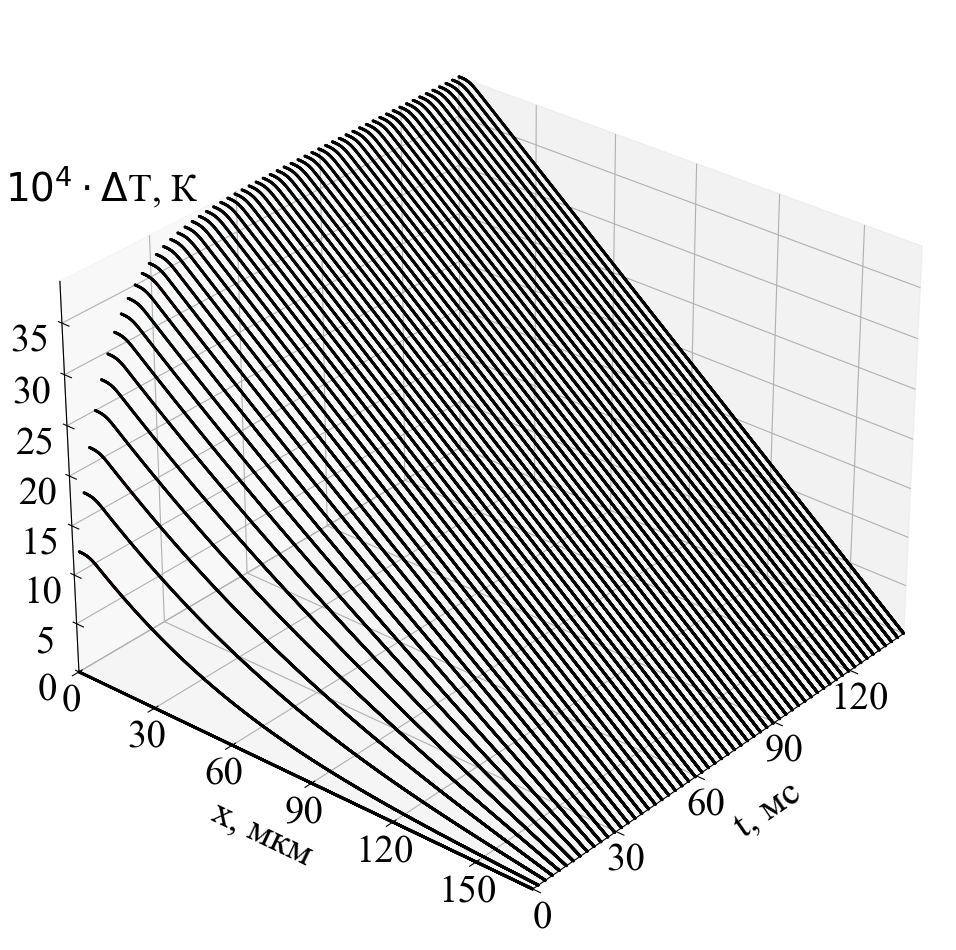

In [115]:
store_path = None
#angle1, angle2 = 30, -50
angle1, angle2 = 30, -50
store_path = 'sample.jpeg'
zlabel_pos = [5, -20, 50]
#zlabel_pos = [10, -20, 33]
eq.plot(1, angle1, angle2, zlabel_pos, dpi=500, labelpad=10, pad_z = 5, pad=-1, 
        font_size_digits=28, font_size_labels=28, store_path=store_path, grid=True)